In [338]:
from keras.layers import Input, Dense, InputLayer
from keras.models import Model, Sequential, load_model
from keras.datasets import mnist
from keras import optimizers, initializers
from keras.utils import to_categorical
from keras import regularizers
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [339]:
# for Decision Tree
from sklearn import tree
from sklearn.metrics import accuracy_score

In [340]:
import sys, os
sys.path.append(os.pardir) 
import h5py # for model file

In [341]:
df = pd.read_csv("../dataset/" + "australian" + "_m0s1.csv", header=None)

In [342]:
k = 0
K = 10
features_length = len(df.columns) - 1
block_size = math.floor(len(df.index) / K)  # test data size for one validation
num_class = max(df.iloc[:, 0]) + 1
print(num_class)

dataset = df
test_range = range(k * block_size, (k + 1) * block_size) # e.g. iris 0~14, 15~29 ...
test = dataset[test_range[0]:test_range[-1] + 1]
dataset = dataset.drop(test_range)
train = dataset

2


In [343]:
x_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0] 
x_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]  

#print(y_train)

y_train = to_categorical(y_train, num_class)
y_test = to_categorical(y_test, num_class)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [344]:
model_dir = "./model_AE/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir, exist_ok=True)

In [359]:
#encoding_dim = 64
#encoding_dim = math.floor(features_length / 2)
#encoding_dim = features_length + 2
encoding_dim = 100

autoencoder1 = Sequential()
autoencoder1.add(InputLayer(input_shape=(features_length,)))
autoencoder1.add(Dense(encoding_dim, activation='relu',\
               activity_regularizer=regularizers.l1(1e-2),\
               kernel_initializer='he_uniform', name='encoded1'
               ))
autoencoder1.add(Dense(features_length, activation='sigmoid', name='decoded'))
                
autoencoder1.compile(optimizer='adam', loss='mean_squared_error', metrics=["acc"])
autoencoder1.summary()
autoencoder1.fit(x_train, x_train,\
                epochs=100,\
                batch_size=256,\
                shuffle=True,\
                #validation_data=(x_test, x_test),\
                validation_split=0.1,\
                verbose=0)
result_train = autoencoder1.evaluate(x_train, x_train, batch_size=32,verbose=0)
result_test = autoencoder1.evaluate(x_train, x_train, batch_size=32,verbose=0)
print(result_train)
print(result_test)

model_name = str(model_dir) + "/encoder1.h5"
autoencoder1.save(model_name)

model_weights = str(model_dir) + "/encoder1_weights.h5"
autoencoder1.save_weights(model_weights)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 14)                0         
_________________________________________________________________
encoded1 (Dense)             (None, 100)               1500      
_________________________________________________________________
decoded (Dense)              (None, 14)                1414      
Total params: 2,914
Trainable params: 2,914
Non-trainable params: 0
_________________________________________________________________
[9.803951386284329, 0.4830917876795678]
[9.803951386284329, 0.4830917876795678]


In [360]:
encoder1 = Model(input=autoencoder1.input, output=autoencoder1.get_layer('encoded1').output)
encoded_data1 = encoder1.predict(x_test)

#print(encoded_data1)
print("encoded1 data mean: ", encoded_data1.mean())

encoded1_train = encoder1.predict(x_train)
encoded1_test = encoder1.predict(x_test)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("en...)`
  """Entry point for launching an IPython kernel.


encoded1 data mean:  0.21419851


In [391]:
encoding_dim2 = encoding_dim

autoencoder2 = Sequential()
autoencoder2.add(Dense(encoding_dim2, input_dim=encoding_dim, activation='relu',\
               activity_regularizer=regularizers.l1(1e-2), \
               kernel_initializer='he_uniform', name='encoded2'
               ))
autoencoder2.add(Dense(encoding_dim, activation='sigmoid', name='decoded2'))

autoencoder2.compile(optimizer='adam', loss='mean_squared_error', metrics=["acc"])
autoencoder2.summary()
autoencoder2.fit(encoded1_train, encoded1_train,\
               epochs=100,\
               batch_size=256,\
               shuffle=True,\
               #validation_data=(encoded1_test, encoded1_test),\
               validation_split=0.1,\
               verbose=0)
result_train = autoencoder2.evaluate(encoded1_train, encoded1_train, batch_size=32,verbose=0)
result_test = autoencoder2.evaluate(encoded1_test, encoded1_test, batch_size=32,verbose=0)
print(result_train)
print(result_test)

model_name2 = str(model_dir) + "/encoder2.h5"
autoencoder2.save(model_name2)

model_weights2 = str(model_dir) + "/encoder2_weights.h5"
autoencoder2.save_weights(model_weights2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded2 (Dense)             (None, 100)               10100     
_________________________________________________________________
decoded2 (Dense)             (None, 100)               10100     
Total params: 20,200
Trainable params: 20,200
Non-trainable params: 0
_________________________________________________________________
[0.32238792782820364, 0.0821256038647343]
[0.24824014651602594, 0.10144927579423656]


In [392]:
encoder2 = Model(input=autoencoder2.input, output=autoencoder2.get_layer('encoded2').output)
encoded_data2 = encoder2.predict(encoded1_test)

#print(encoded_data2)
print("encoded2 data mean: ", encoded_data2.mean())

encoded2_train = encoder2.predict(encoded1_train)
encoded2_test = encoder2.predict(encoded1_test)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("en..., outputs=Tensor("en...)`
  """Entry point for launching an IPython kernel.


encoded2 data mean:  0.00019092948


In [410]:
encoding_dim3 = encoding_dim2

autoencoder3 = Sequential()
autoencoder3.add(Dense(encoding_dim3, input_dim=encoding_dim2, activation='relu',\
               activity_regularizer=regularizers.l1(1e-2), \
               kernel_initializer='he_uniform', name='encoded3'
               ))
autoencoder3.add(Dense(encoding_dim2, activation='sigmoid', name='decoded3'))

autoencoder3.compile(optimizer='adam', loss='mean_squared_error', metrics=["acc"])
autoencoder3.summary()
autoencoder3.fit(encoded2_train, encoded2_train,\
               epochs=30,\
               batch_size=256,\
               shuffle=True,\
               #validation_data=(encoded2_test, encoded2_test),\
               validation_split=0.1,\
               verbose=0)
result_train = autoencoder3.evaluate(encoded2_train, encoded2_train, batch_size=32,verbose=0)
result_test = autoencoder3.evaluate(encoded2_test, encoded2_test, batch_size=32,verbose=0)
print(result_train)
print(result_test)

model_name3 = str(model_dir) + "/encoder3.h5"
autoencoder3.save(model_name3)

model_weights3 = str(model_dir) + "/encoder3_weights.h5"
autoencoder3.save_weights(model_weights3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded3 (Dense)             (None, 100)               10100     
_________________________________________________________________
decoded3 (Dense)             (None, 100)               10100     
Total params: 20,200
Trainable params: 20,200
Non-trainable params: 0
_________________________________________________________________
[0.22955718703699957, 0.001610305958132045]
[0.23102852961291437, 0.0]


In [411]:
encoder3 = Model(input=autoencoder3.input, output=autoencoder3.get_layer('encoded3').output)
encoded_data3 = encoder3.predict(encoded2_test)

#print(encoded_data3)
print("encoded3 data mean: ", encoded_data3.mean())

encoded3_train = encoder3.predict(encoded2_train)
encoded3_test = encoder3.predict(encoded2_test)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("en..., outputs=Tensor("en...)`
  """Entry point for launching an IPython kernel.


encoded3 data mean:  0.00010525614


In [412]:
autoencoder_main = Sequential()
autoencoder_main.add(InputLayer(input_shape=(features_length,)))
autoencoder_main.add(Dense(encoding_dim, activation='relu', name='encoded1'))
autoencoder_main.add(Dense(encoding_dim2, activation='relu', name='encoded2'))
autoencoder_main.add(Dense(encoding_dim3, activation='relu', name='encoded3'))

autoencoder_main.add(Dense(num_class, activation='softmax', name='decoded_main'))
autoencoder_main.load_weights(model_weights, by_name=True)
autoencoder_main.load_weights(model_weights2, by_name=True)
autoencoder_main.load_weights(model_weights3, by_name=True)

#autoencoder_main.layers[1].trainable = False
#autoencoder_main.layers[2].trainable = False

autoencoder_main.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["acc"])
autoencoder_main.summary()
fit = autoencoder_main.fit(x_train, y_train,\
               epochs=500,\
               batch_size=256,\
               shuffle=True,\
               #validation_data=(x_test, y_test),\
               validation_split=0.1, \
               verbose=0)
result_train = autoencoder_main.evaluate(x_train, y_train, batch_size=32,verbose=0)
result_test = autoencoder_main.evaluate(x_test, y_test, batch_size=32,verbose=0)
print(result_train)
print(result_test)

model_main_name = str(model_dir) + "/encoder_main.h5"
autoencoder_main.save(model_main_name)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        (None, 14)                0         
_________________________________________________________________
encoded1 (Dense)             (None, 100)               1500      
_________________________________________________________________
encoded2 (Dense)             (None, 100)               10100     
_________________________________________________________________
encoded3 (Dense)             (None, 100)               10100     
_________________________________________________________________
decoded_main (Dense)         (None, 2)                 202       
Total params: 21,902
Trainable params: 21,902
Non-trainable params: 0
_________________________________________________________________
[0.16391236230659023, 0.9677938809333408]
[1.2322082435307296, 0.8840579710144928]


In [437]:
encoder_main = Model(input=autoencoder_main.input, output=autoencoder_main.get_layer('encoded3').output)
encoded_main_data = encoder_main.predict(x_test)

#print(encoded_main_data)
print("encoded_main data mean: ", encoded_main_data.mean())
#print(encoder_main.get_weights())

encoded_main_train = encoder_main.predict(x_train)
encoded_main_test = encoder_main.predict(x_test)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("en...)`
  """Entry point for launching an IPython kernel.


encoded_main data mean:  0.28209347
[array([[ 0.31027654,  0.01866799,  0.02963032, ..., -0.16184582,
        -0.2652243 ,  0.00696036],
       [-0.3000321 , -0.5334167 , -0.96606493, ...,  0.45657772,
        -0.3454704 , -0.98302114],
       [ 0.26845813,  0.6089409 , -0.40045467, ...,  1.0575905 ,
         0.6681178 , -0.6900339 ],
       ...,
       [ 0.16999954, -0.01692866, -0.24318428, ...,  0.19634783,
         0.02536914, -0.18015309],
       [-0.27923858, -1.2167945 ,  1.2083915 , ..., -0.15714212,
         0.05724715,  0.02002099],
       [-0.35121873, -0.03594176, -0.22839765, ..., -0.31163922,
        -0.75310093, -1.2901999 ]], dtype=float32), array([-0.26843673, -0.25118244, -0.24797411, -0.3382082 , -0.22051048,
       -0.17015487, -0.28925228, -0.27603093, -0.2843411 , -0.29204583,
       -0.27417806, -0.23071198, -0.27451947, -0.24787991, -0.23392779,
       -0.2261708 , -0.33978435, -0.21106097, -0.2837316 , -0.21779864,
       -0.24100406, -0.21531782, -0.2647811 , 

In [436]:
# make Decision Tree from hidden layer output
clf = tree.DecisionTreeClassifier(presort=True)
clf = clf.fit(encoded_main_train, y_train)
predict_tree_train = clf.predict(encoded_main_train)
predict_tree_test = clf.predict(encoded_main_test)
acc_tree_train = accuracy_score(y_train, predict_tree_train)
acc_tree_test = accuracy_score(y_test, predict_tree_test)
print(acc_tree_train)
print(acc_tree_test)

0.9903381642512077
0.8695652173913043


In [415]:
node = clf.tree_.feature
node_num = len(node)
print(node_num)

33


In [416]:
clf_raw = tree.DecisionTreeClassifier(presort=True)
clf_raw = clf_raw.fit(x_train, y_train)
predict_raw_train = clf_raw.predict(x_train)
predict_raw_test = clf_raw.predict(x_test)
acc_raw_train = accuracy_score(predict_raw_train, y_train)
acc_raw_test = accuracy_score(predict_raw_test, y_test)
print(acc_raw_train)
print(acc_raw_test)

1.0
0.8695652173913043


In [417]:
node_raw = clf_raw.tree_.feature
node_raw_num = len(node_raw)
print(node_raw_num)

157


In [357]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(621, 14)
(69, 14)
(621, 2)
(69, 2)


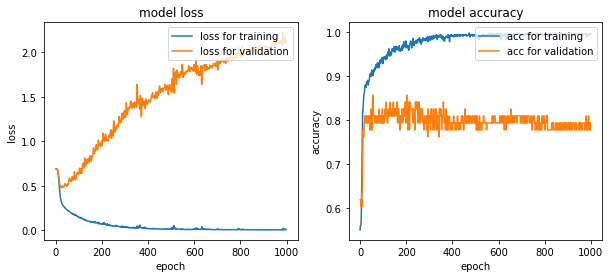

In [389]:
# ----------------------------------------------
# Some plots
# ----------------------------------------------
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

# loss
def plot_history_loss(fit):
    # Plot the loss in the history
    axL.plot(fit.history['loss'],label="loss for training")
    axL.plot(fit.history['val_loss'],label="loss for validation")
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
    axL.legend(loc='upper right')

# acc
def plot_history_acc(fit):
    # Plot the loss in the history
    axR.plot(fit.history['acc'],label="acc for training")
    axR.plot(fit.history['val_acc'],label="acc for validation")
    axR.set_title('model accuracy')
    axR.set_xlabel('epoch')
    axR.set_ylabel('accuracy')
    axR.legend(loc='upper right')

plot_history_loss(fit)
plot_history_acc(fit)
plt.show()
fig.savefig('./loss_cancer.png')
plt.close()